# Packages and Data loading

## packages

In [11]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
import time
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')
from time import time

from sklearn.metrics import make_scorer
from sklearn.externals import joblib

#json
import ujson as json

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 13

## data preparation

### reading (train, test)

In [7]:
#reading
PATH_TO_DATA = Path('../input/Dota_2/')
train_df = pd.read_csv(PATH_TO_DATA/'train_features.csv', index_col='match_id_hash')
test_df = pd.read_csv(PATH_TO_DATA/'test_features.csv', index_col='match_id_hash')

# get target
train_y = pd.read_csv(PATH_TO_DATA/'train_targets.csv', index_col='match_id_hash')
train_y['radiant_win'] = train_y['radiant_win'].map({False: 0, True: 1})

# set target to train
train_df['radiant_win'] = train_y['radiant_win']

# X, y
y = train_df['radiant_win']
X = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test = test_df.copy().reset_index(drop=True)

train_df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0,0,0.00,0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0,0.00,0,0,0,0,1
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0,0.00,0,0,0,0,1
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,3,1,3,0,0.00,0,0,2,0,1
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,2,1,2,0,0.25,0,0,0,0,0


### Сразу ок фичи
Альтернативный путь - сразу подгрузить датасеты, полученные на 5м шаге

In [2]:
PATH_TO_DATA = Path('../input/Dota_2/')

train_df = pd.read_csv(PATH_TO_DATA/'train_model_2.csv', index_col='match_id_hash')
test_df = pd.read_csv(PATH_TO_DATA/'test_model_2.csv', index_col='match_id_hash')



y = train_df['radiant_win']
X5 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X5_test = test_df.copy().reset_index(drop=True)
train_df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.800000,3,2,1.5,0.894427,0.894427,1.0,0.6,0.4,1.5
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,NaN,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,1.333333,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,NaN,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN


Получается у нас будет теперь пачка датаФреймов

- train_df - оригинальный df Yorko, с целевой переменной
- test_df - также оригинальный тестовый df, без целевой переменной, конечно
- full_df - комба из train_df(без target) и test_df
- target - оригинальный итоговый df, с 4 колонками


- y - чисто колонка целевой переменной, для предсказаний
- X - обучающий набор с выпиленым target
- X_test - практически оригинальный тестовый df

#  Train Function, Feature Importance Func and First Model

## Training function

In [51]:
def get_col_ind(df):
    cat_features = []
    cat_column_names = list(df.select_dtypes(include=['category']))
    for col in cat_column_names:
        cat_features.append(df.columns.get_loc(col))
    return cat_features

In [52]:
def train_model(X, X_test, y, params, folds, rand_state, model_type='cat', averaging='usual', model=None):
    
    # индексы категориальных фич
    cat_features = get_col_ind(X)
    
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in tqdm(enumerate(folds.split(X, y))):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'cat':
            model = CatBoostClassifier(**params, random_state=rand_state)
            model.fit(X_train, 
                      y_train, 
                      eval_set=(X_valid, y_valid), 
                      cat_features=cat_features, 
                      use_best_model=True, 
                      verbose=500)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
            
    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    return oof, prediction, scores, model

## Params

In [9]:
# fast
params_cat = {
    'iterations' : 1000,
    'learning_rate' : 0.05,
    'loss_function':'Logloss',
    'eval_metric':'AUC', 
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
#     'logging_level': 'Info', 
         }

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

# balance
# params_cat = {
#     'iterations' : 20000,
#     'learning_rate' : 0.05,
#     'loss_function':'Logloss',
#     'eval_metric':'AUC', 
#     'task_type': 'GPU',
#     'early_stopping_rounds': 200,
#     'logging_level': 'Info', 
#          }

# best score
# params_cat = {
#     'iterations' : 20000,
#     'learning_rate' : 0.05,
#     'loss_function':'Logloss',
#     'eval_metric':'AUC', 
#     'task_type': 'GPU',
#          }

## Create and train first model

In [7]:
cat_cols_ind = []

In [44]:
oof_cat, prediction_cat, scores_cat, cat_model = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  plot_feature_importance=True)

Fold 0 started at Tue Nov 12 22:09:23 2019
0:	learn: 0.6987239	test: 0.6827227	best: 0.6827227 (0)	total: 187ms	remaining: 3m 6s
500:	learn: 0.8621934	test: 0.8016110	best: 0.8016531 (495)	total: 1m 21s	remaining: 1m 21s
999:	learn: 0.8993212	test: 0.8060931	best: 0.8062073 (968)	total: 2m 37s	remaining: 0us
bestTest = 0.8062072992
bestIteration = 968
Shrink model to first 969 iterations.
Fold 1 started at Tue Nov 12 22:12:06 2019
0:	learn: 0.7029142	test: 0.6834864	best: 0.6834864 (0)	total: 184ms	remaining: 3m 3s
500:	learn: 0.8575337	test: 0.7888767	best: 0.7888790 (498)	total: 1m 18s	remaining: 1m 18s
999:	learn: 0.8872769	test: 0.7929685	best: 0.7930542 (984)	total: 2m 31s	remaining: 0us
bestTest = 0.7930542231
bestIteration = 984
Shrink model to first 985 iterations.
Fold 2 started at Tue Nov 12 22:14:41 2019
0:	learn: 0.6997987	test: 0.6876777	best: 0.6876777 (0)	total: 180ms	remaining: 2m 59s
500:	learn: 0.8592522	test: 0.8008893	best: 0.8010347 (489)	total: 1m 20s	remaining: 1

## Feature Importance Function

### GOOD: First way

In [54]:
def feature_importance(model, df_train, y):
    cat_features = get_col_ind(df_train)
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[:50]
    
    plt.rcParams["figure.figsize"] = (16,9)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='r')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

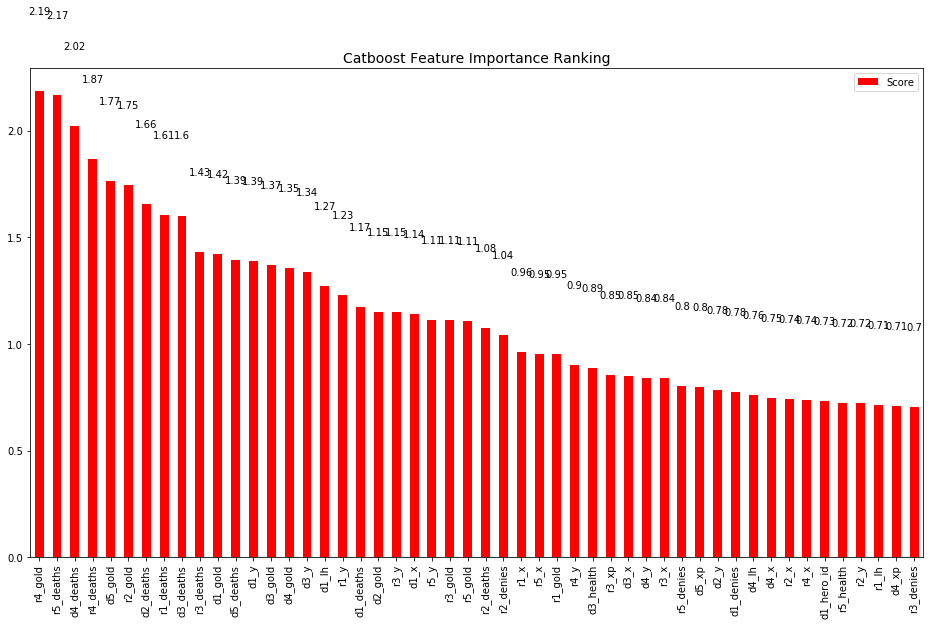

In [57]:
feature_importance(cat_model, train_df, train_y, cat_cols_ind)

### GOOD: Second way

In [55]:
def feature_importance_sns(model, df_train, y, figSize = (16,12)):
    cat_features = get_col_ind(df_train)
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                    columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[:50]
    plt.figure(figsize=figSize);
    sns.barplot(x="Score", y="Feature", data=feature_score);
    plt.title('CatBoost Features');

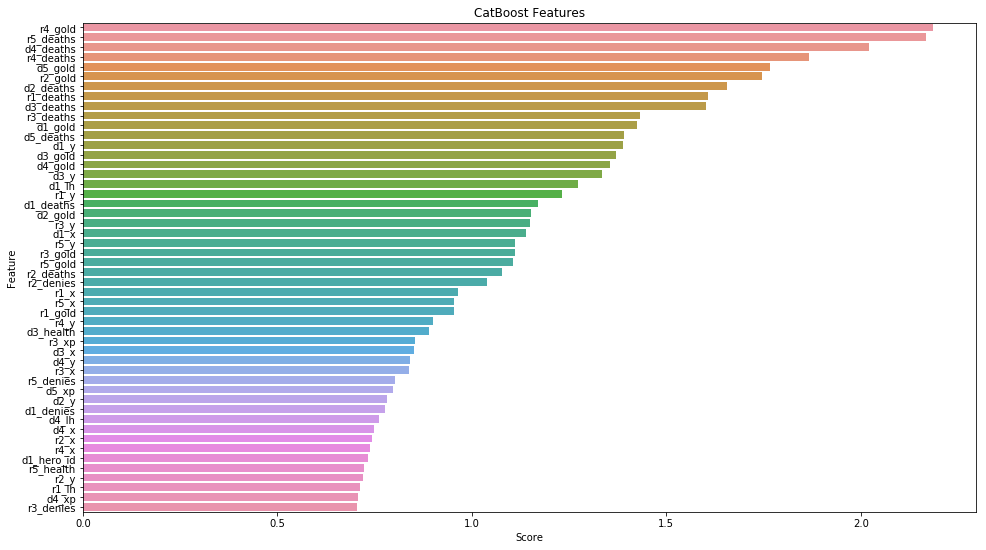

In [58]:
feature_importance_sns(cat_model, X, y, cat_cols_ind, figSize = (16,9))

### BAD

In [56]:
# подумать как нормально отсев по порогу запилить
def feature_importance_bad(model, df_train, y, figSize = (16,12), threshhold = 0.0, n = 50):
    cat_features = get_col_ind(df_train)
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                    columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=True, inplace=False, kind='quicksort', na_position='last')[:n]
    plt.figure(figsize=figSize);
    sns.barplot(x="Score", y="Feature", data=feature_score);
    plt.title('CatBoost Features');
    feature_score.head()
    return list(feature_score['Feature'])

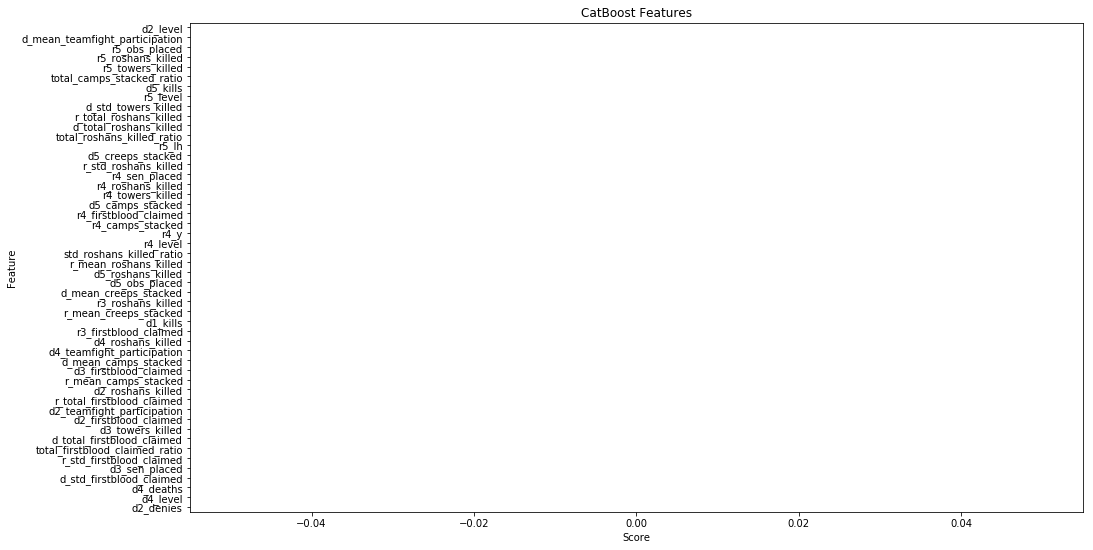

In [76]:
bad = feature_importance_bad(cat_model_2, X, y, cat_cols_ind, figSize = (16,9), n=50)

In [77]:
print(bad)

['d2_level', 'd_mean_teamfight_participation', 'r5_obs_placed', 'r5_roshans_killed', 'r5_towers_killed', 'total_camps_stacked_ratio', 'd5_kills', 'r5_level', 'd_std_towers_killed', 'r_total_roshans_killed', 'd_total_roshans_killed', 'total_roshans_killed_ratio', 'r5_lh', 'd5_creeps_stacked', 'r_std_roshans_killed', 'r4_sen_placed', 'r4_roshans_killed', 'r4_towers_killed', 'd5_camps_stacked', 'r4_firstblood_claimed', 'r4_camps_stacked', 'r4_y', 'r4_level', 'std_roshans_killed_ratio', 'r_mean_roshans_killed', 'd5_roshans_killed', 'd5_obs_placed', 'd_mean_creeps_stacked', 'r3_roshans_killed', 'r_mean_creeps_stacked', 'd1_kills', 'r3_firstblood_claimed', 'd4_roshans_killed', 'd4_teamfight_participation', 'd_mean_camps_stacked', 'd3_firstblood_claimed', 'r_mean_camps_stacked', 'd2_roshans_killed', 'r_total_firstblood_claimed', 'd2_teamfight_participation', 'd2_firstblood_claimed', 'd3_towers_killed', 'd_total_firstblood_claimed', 'total_firstblood_claimed_ratio', 'r_std_firstblood_claimed',

# EDA and Feature Enginering

## Feature Enginering

### Feature engineering on basic data. Model 2


from https://www.kaggle.com/alekseytheblack/dota-eda-fe-and-models/edit,


My idea behind this FE is the following:
Let's take gold, for example. Gold earned by each player can't give us a lot of information. But what is we take total gold by the team? Maybe teams with more gold earned usually win. What if we take mean and std of players' gold in a team? Maybe teams where players tend to have similar parameters are more likely to win. Let's try creating these features.

#### Feature creating

In [13]:
for c in tqdm(['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['r_total_' + c] = train_df[r_columns].sum(1)
    train_df['d_total_' + c] = train_df[d_columns].sum(1)
    train_df['total_' + c + '_ratio'] = train_df['r_total_' + c] / train_df['d_total_' + c]
    
    test_df['r_total_' + c] = test_df[r_columns].sum(1)
    test_df['d_total_' + c] = test_df[d_columns].sum(1)
    test_df['total_' + c + '_ratio'] = test_df['r_total_' + c] / test_df['d_total_' + c]
    
    train_df['r_std_' + c] = train_df[r_columns].std(1)
    train_df['d_std_' + c] = train_df[d_columns].std(1)
    train_df['std_' + c + '_ratio'] = train_df['r_std_' + c] / train_df['d_std_' + c]
    
    test_df['r_std_' + c] = test_df[r_columns].std(1)
    test_df['d_std_' + c] = test_df[d_columns].std(1)
    test_df['std_' + c + '_ratio'] = test_df['r_std_' + c] / test_df['d_std_' + c]
    
    train_df['r_mean_' + c] = train_df[r_columns].mean(1)
    train_df['d_mean_' + c] = train_df[d_columns].mean(1)
    train_df['mean_' + c + '_ratio'] = train_df['r_mean_' + c] / train_df['d_mean_' + c]
    
    test_df['r_mean_' + c] = test_df[r_columns].mean(1)
    test_df['d_mean_' + c] = test_df[d_columns].mean(1)
    test_df['mean_' + c + '_ratio'] = test_df['r_mean_' + c] / test_df['d_mean_' + c]

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.34it/s]


In [14]:
X = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test = test_df.copy().reset_index(drop=True)

#### Save 

In [17]:
train_df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.800000,3,2,1.5,0.894427,0.894427,1.0,0.6,0.4,1.5
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,NaN,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,1.333333,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,NaN,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN


In [18]:
def save_train_and_test_csv(model_name):
    export_csv = train_df.to_csv (os.path.join(PATH_TO_DATA, f'train_model_{model_name}.csv'),
                                  index = True,
                                  header=True)
    export_csv = test_df.to_csv (os.path.join(PATH_TO_DATA, f'test_model_{model_name}.csv'),
                                  index = True,
                                  header=True)

In [19]:
save_train_and_test_csv(2)

#### Model 2

In [49]:
oof_cat_2, prediction_cat_2, scores_cat_2, cat_model_2 = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state = RANDOM_STATE)

Fold 0 started at Wed Nov 13 07:58:29 2019
0:	learn: 0.8038437	test: 0.7996361	best: 0.7996361 (0)	total: 229ms	remaining: 3m 49s
bestTest = 0.824164778
bestIteration = 221
Shrink model to first 222 iterations.
Fold 1 started at Wed Nov 13 08:00:05 2019
0:	learn: 0.8079559	test: 0.7932032	best: 0.7932032 (0)	total: 227ms	remaining: 3m 46s
500:	learn: 0.8723126	test: 0.8146046	best: 0.8150036 (403)	total: 1m 48s	remaining: 1m 48s
bestTest = 0.8152509332
bestIteration = 673
Shrink model to first 674 iterations.
Fold 2 started at Wed Nov 13 08:03:15 2019
0:	learn: 0.8027997	test: 0.8072614	best: 0.8072614 (0)	total: 230ms	remaining: 3m 49s
500:	learn: 0.8661022	test: 0.8278545	best: 0.8280169 (472)	total: 1m 44s	remaining: 1m 44s
bestTest = 0.8280169368
bestIteration = 472
Shrink model to first 473 iterations.
Fold 3 started at Wed Nov 13 08:05:37 2019
0:	learn: 0.8011754	test: 0.8054701	best: 0.8054701 (0)	total: 226ms	remaining: 3m 46s
500:	learn: 0.8696356	test: 0.8298326	best: 0.82988

#### Feature importance model 2

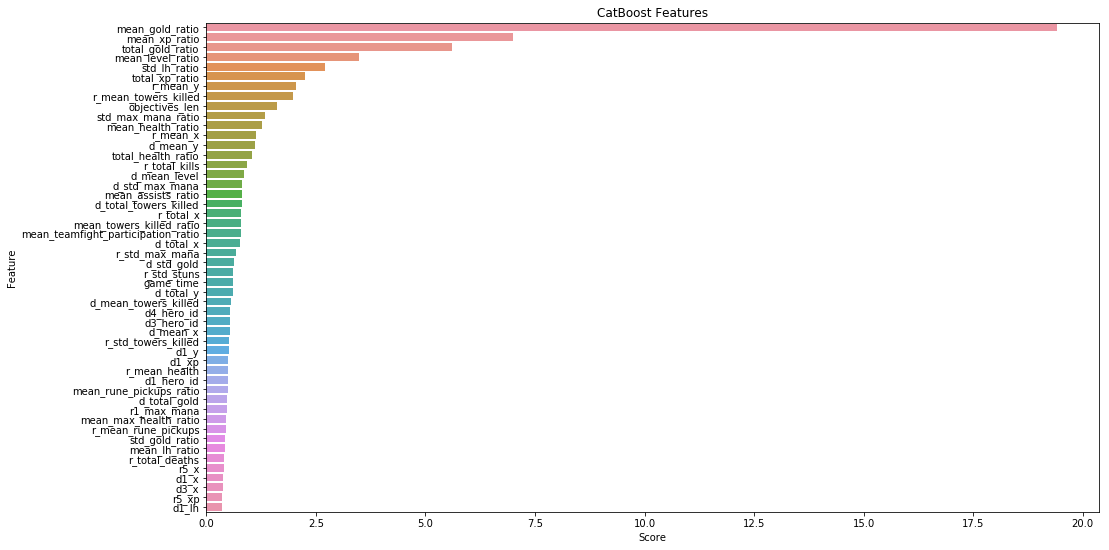

In [50]:
feature_importance_sns(cat_model_2, X, y, cat_cols_ind, figSize = (16,9))

#### Sybmission model 2

In [51]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_2
sub.to_csv('submission_catBoost_model2.csv', index=False)
sub.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.562010
1,70e5ba30f367cea48793b9003fab9d38,0.974557
2,4d9ef74d3a2025d79e9423105fd73d41,0.967287
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.797400
4,bec17f099b01d67edc82dfb5ce735a43,0.400699


#### Model 2 v 2. Drop useless features

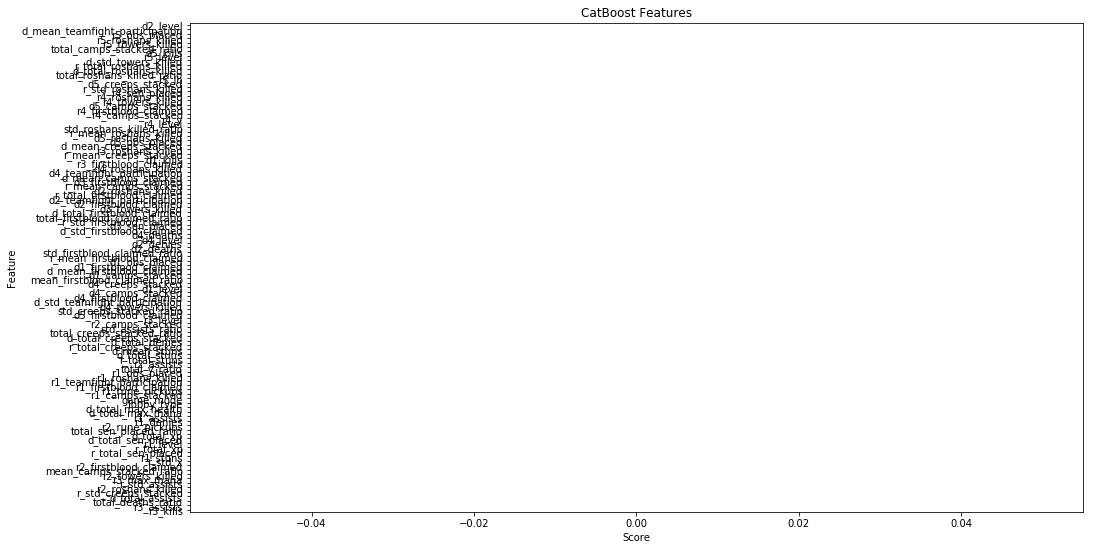

In [81]:
bad_1 = feature_importance_bad(cat_model_2, X, y, cat_cols_ind, figSize = (16,9), n=110)

In [82]:
train_df  = train_df.drop(bad_1, axis = 1)
test_df = test_df.drop(bad_1, axis = 1)
X = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test = test_df.copy().reset_index(drop=True)

In [83]:
%%time
oof_cat_2, prediction_cat_2, scores_cat_2, cat_model_2 = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state = RANDOM_STATE)

Fold 0 started at Wed Nov 13 08:33:31 2019
0:	learn: 0.8039632	test: 0.8000876	best: 0.8000876 (0)	total: 207ms	remaining: 3m 26s
500:	learn: 0.8700676	test: 0.8236288	best: 0.8238385 (458)	total: 1m 37s	remaining: 1m 36s
bestTest = 0.8238384724
bestIteration = 458
Shrink model to first 459 iterations.
Fold 1 started at Wed Nov 13 08:35:41 2019
0:	learn: 0.8063190	test: 0.7915308	best: 0.7915308 (0)	total: 204ms	remaining: 3m 23s
500:	learn: 0.8749483	test: 0.8148150	best: 0.8149669 (443)	total: 1m 38s	remaining: 1m 38s
bestTest = 0.815390408
bestIteration = 751
Shrink model to first 752 iterations.
Fold 2 started at Wed Nov 13 08:38:49 2019
0:	learn: 0.8029119	test: 0.8058361	best: 0.8058361 (0)	total: 207ms	remaining: 3m 26s
500:	learn: 0.8685411	test: 0.8274091	best: 0.8276647 (449)	total: 1m 38s	remaining: 1m 37s
999:	learn: 0.8902797	test: 0.8274668	best: 0.8278124 (807)	total: 3m 8s	remaining: 0us
bestTest = 0.8278124332
bestIteration = 807
Shrink model to first 808 iterations.
F

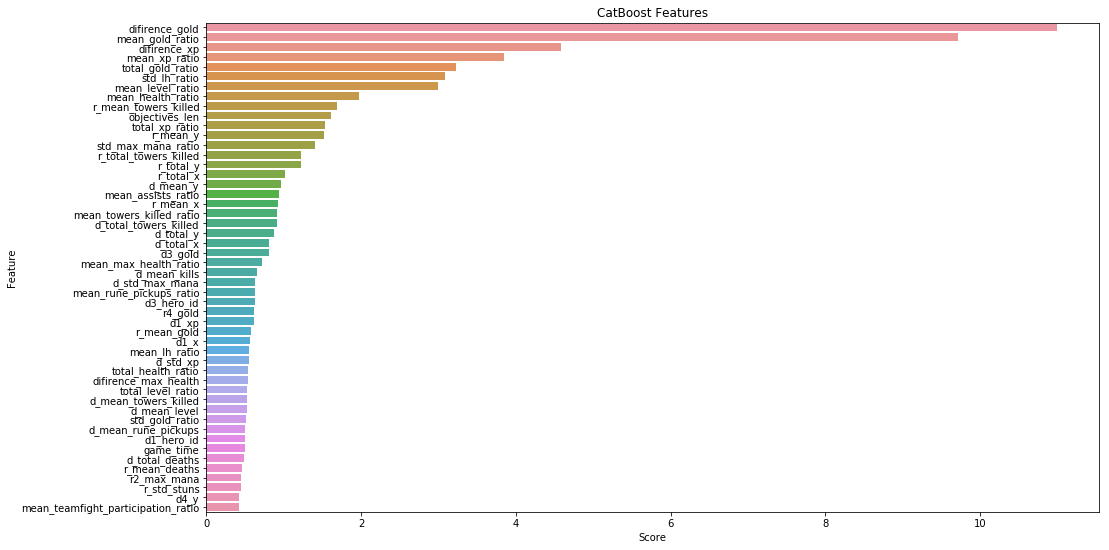

In [84]:
feature_importance_sns(cat_model_2, X, y, cat_cols_ind, figSize = (16,9))

### gold percent, kills percent and other, Model 3

#### gold percent, kills percent and other

Идея в том, что важен не разрыв по голде, а отношение

Считаем (голда света - голда тьмы) / (голда света + голда тьмы)

Если например 3\4 голды у одной тимы, второй, скорее всего, пизда.

In [26]:
for c in tqdm(['kills','gold', 'towers_killed', 'max_health', 'max_mana', 'level', 'roshans_killed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['difirence_' + c] = (train_df['r_total_' + c] - train_df['d_total_' + c]) / (train_df['r_total_' + c] + train_df['d_total_' + c])
    test_df['difirence_' + c] = (test_df['r_total_' + c] - test_df['d_total_' + c]) / (test_df['r_total_' + c] + test_df['d_total_' + c])

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 226.04it/s]


In [27]:
X3 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test3 = test_df.copy().reset_index(drop=True)
X3.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio,difirence_kills,difirence_gold,difirence_towers_killed,difirence_max_health,difirence_max_mana,difirence_level,difirence_roshans_killed
0,155,22,7,1,11,11,0,0,0,0,...,0.0,0.0,NaN,-1.000000,-0.319298,NaN,0.000000,-0.132659,-0.181818,NaN
1,658,4,0,3,10,15,7,2,0,7,...,0.6,0.4,1.5,0.684211,0.160557,1.0,0.070248,0.041403,0.104478,NaN
2,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,NaN,NaN,0.294118,NaN,-0.003155,0.025788,0.000000,NaN
3,576,22,7,1,4,14,1,0,3,1,...,0.0,0.0,NaN,0.714286,0.083046,NaN,-0.008403,0.081269,0.066667,NaN
4,453,22,7,1,3,42,0,1,1,0,...,0.0,0.0,NaN,-0.333333,-0.063630,NaN,0.088785,0.093908,-0.019608,NaN


#### Save

In [28]:
save_train_and_test_csv(3)

#### Model 3

In [114]:
oof_cat_3, prediction_cat_3, scores_cat_3, cat_model_3 = train_model(X3,
                                                  X_test3,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)

Fold 0 started at Wed Nov 13 09:32:57 2019
0:	learn: 0.8038437	test: 0.7996361	best: 0.7996361 (0)	total: 230ms	remaining: 3m 49s
500:	learn: 0.8734941	test: 0.8233171	best: 0.8235645 (398)	total: 1m 48s	remaining: 1m 48s
bestTest = 0.8235644698
bestIteration = 398
Shrink model to first 399 iterations.
Fold 1 started at Wed Nov 13 09:35:10 2019
0:	learn: 0.8079559	test: 0.7932032	best: 0.7932032 (0)	total: 229ms	remaining: 3m 48s
500:	learn: 0.8715804	test: 0.8144110	best: 0.8144110 (500)	total: 1m 46s	remaining: 1m 46s
bestTest = 0.8144162297
bestIteration = 529
Shrink model to first 530 iterations.
Fold 2 started at Wed Nov 13 09:37:49 2019
0:	learn: 0.8027997	test: 0.8072614	best: 0.8072614 (0)	total: 233ms	remaining: 3m 52s
500:	learn: 0.8653548	test: 0.8275172	best: 0.8276118 (475)	total: 1m 45s	remaining: 1m 45s
999:	learn: 0.8910971	test: 0.8283653	best: 0.8286263 (960)	total: 3m 27s	remaining: 0us
bestTest = 0.8286263347
bestIteration = 960
Shrink model to first 961 iterations.

#### Feature importance model 3

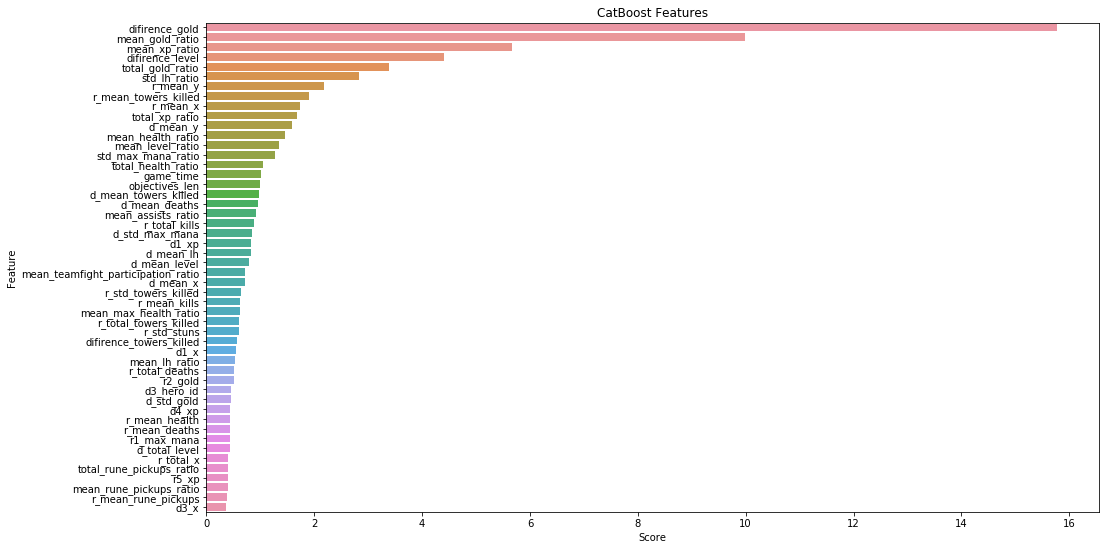

In [115]:
feature_importance_sns(cat_model_3, X3, y, cat_cols_ind, figSize = (16,9))

In [117]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_3
sub.to_csv('submission_catBoost_model_3.csv', index=False)
sub.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.539328
1,70e5ba30f367cea48793b9003fab9d38,0.977078
2,4d9ef74d3a2025d79e9423105fd73d41,0.967499
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.782583
4,bec17f099b01d67edc82dfb5ce735a43,0.395920


#### Model 3.1 with feature tuning (fix NaN)

Уберем NaN из значений, которые извользуется при расчете

In [111]:
train_df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio,difirence_kills,difirence_gold,difirence_towers_killed,difirence_max_health,difirence_max_mana,difirence_level,difirence_roshans_killed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0.0,NaN,-1.000000,-0.319298,NaN,0.000000,-0.132659,-0.181818,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.6,0.4,1.5,0.684211,0.160557,1.0,0.070248,0.041403,0.104478,NaN
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,NaN,NaN,0.294118,NaN,-0.003155,0.025788,0.000000,NaN
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,0.0,0.0,NaN,0.714286,0.083046,NaN,-0.008403,0.081269,0.066667,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.0,0.0,NaN,-0.333333,-0.063630,NaN,0.088785,0.093908,-0.019608,NaN


In [109]:
for c in tqdm(['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['r_total_' + c] = train_df['r_total_' + c].fillna(0)
    train_df['d_total_' + c] = train_df['d_total_' + c].fillna(0)
    
#     test_df['r_total_' + c] = test_df[r_columns].sum(1)
#     test_df['d_total_' + c] = test_df[d_columns].sum(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.36it/s]


Пересчитаем значения для 3й модели без НаН

In [110]:
for c in tqdm(['kills','gold', 'towers_killed', 'max_health', 'max_mana', 'level', 'roshans_killed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['difirence_' + c] = (train_df['r_total_' + c] - train_df['d_total_' + c]) / (train_df['r_total_' + c] + train_df['d_total_' + c])
    test_df['difirence_' + c] = (test_df['r_total_' + c] - test_df['d_total_' + c]) / (test_df['r_total_' + c] + test_df['d_total_' + c])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]


Запустим обучение и остальное заного

In [ ]:
X3_1 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test3_1 = test_df.copy().reset_index(drop=True)

### Heroes_ID to categorical - model 4

https://www.kaggle.com/utapyngo/dota-2-how-to-make-use-of-hero-ids

to categorical

In [29]:
hero_columns = [c for c in train_df.columns if '_hero_' in c]
train_df[hero_columns]= train_df[hero_columns].astype('category')
test_df[hero_columns]= test_df[hero_columns].astype('category')

#### data for model 4

In [30]:
X4 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test4 = test_df.copy().reset_index(drop=True)
X4.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio,difirence_kills,difirence_gold,difirence_towers_killed,difirence_max_health,difirence_max_mana,difirence_level,difirence_roshans_killed
0,155,22,7,1,11,11,0,0,0,0,...,0.0,0.0,NaN,-1.000000,-0.319298,NaN,0.000000,-0.132659,-0.181818,NaN
1,658,4,0,3,10,15,7,2,0,7,...,0.6,0.4,1.5,0.684211,0.160557,1.0,0.070248,0.041403,0.104478,NaN
2,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,NaN,NaN,0.294118,NaN,-0.003155,0.025788,0.000000,NaN
3,576,22,7,1,4,14,1,0,3,1,...,0.0,0.0,NaN,0.714286,0.083046,NaN,-0.008403,0.081269,0.066667,NaN
4,453,22,7,1,3,42,0,1,1,0,...,0.0,0.0,NaN,-0.333333,-0.063630,NaN,0.088785,0.093908,-0.019608,NaN


#### Save

In [31]:
save_train_and_test_csv(4)

#### model 4

In [19]:
oof_cat_4, prediction_cat_4, scores_cat_4, cat_model_4 = train_model(X4,
                                                  X_test4,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=col_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)

Fold 0 started at Wed Nov 13 11:41:26 2019
0:	learn: 0.8051877	test: 0.8024078	best: 0.8024078 (0)	total: 396ms	remaining: 6m 35s
500:	learn: 0.8686193	test: 0.8235604	best: 0.8236393 (497)	total: 3m 2s	remaining: 3m 1s
bestTest = 0.82364434
bestIteration = 509
Shrink model to first 510 iterations.
Fold 1 started at Wed Nov 13 11:45:51 2019
0:	learn: 0.8078225	test: 0.7944507	best: 0.7944507 (0)	total: 395ms	remaining: 6m 34s
500:	learn: 0.8708820	test: 0.8135591	best: 0.8136705 (346)	total: 3m 7s	remaining: 3m 6s
bestTest = 0.8136704564
bestIteration = 346
Shrink model to first 347 iterations.
Fold 2 started at Wed Nov 13 11:49:24 2019
0:	learn: 0.8033893	test: 0.8072647	best: 0.8072647 (0)	total: 390ms	remaining: 6m 29s
500:	learn: 0.8674794	test: 0.8266718	best: 0.8266718 (500)	total: 3m 11s	remaining: 3m 10s
bestTest = 0.8268956542
bestIteration = 623
Shrink model to first 624 iterations.
Fold 3 started at Wed Nov 13 11:54:43 2019
0:	learn: 0.8021267	test: 0.8068317	best: 0.8068317

#### Feature importance model 4

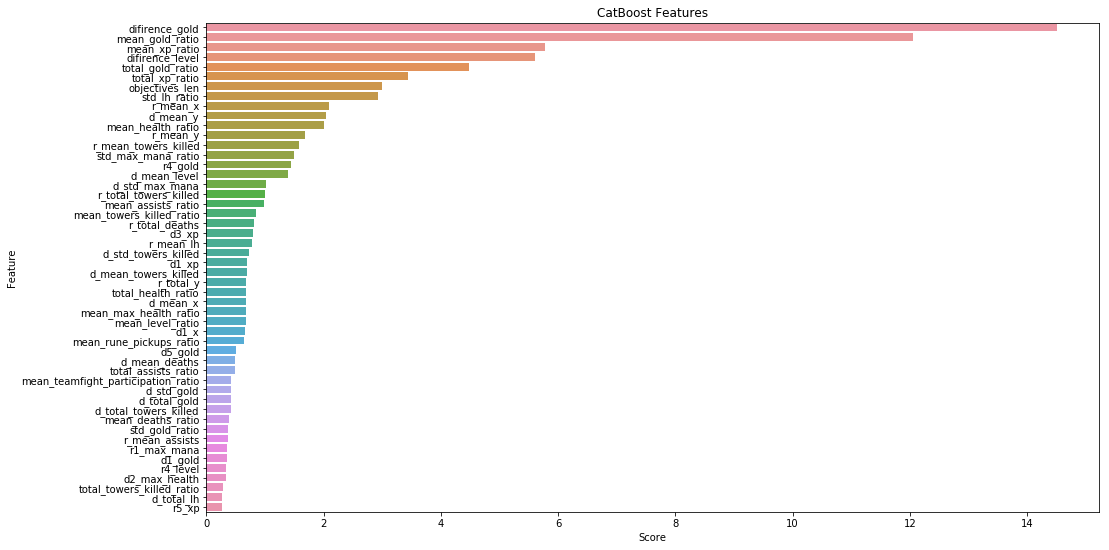

In [20]:
feature_importance_sns(cat_model_4, X4, y, col_ind, figSize = (16,9))

#### Попробуем one-hot encoding

### Tower kills - model 5

https://www.kaggle.com/vchulski/dota-2-catboost-and-shap-explainer

#### ad features

In [32]:
#a helper function, we will use it in next cell
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            yield json.loads(line)

In [33]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills

In [34]:
%%time
# add new features

pd.read_csv(PATH_TO_DATA/'test_features.csv', index_col='match_id_hash')

add_new_features(train_df, os.path.join(PATH_TO_DATA, 'train_matches.jsonl'))
add_new_features(test_df, os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.09it/s]


Wall time: 2min 41s


#### Save Model 5 data

In [35]:
save_train_and_test_csv(5)

#### prepare data for model 5

In [35]:
X5 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test5 = test_df.copy().reset_index(drop=True)
X5.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,difirence_kills,difirence_gold,difirence_towers_killed,difirence_max_health,difirence_max_mana,difirence_level,difirence_roshans_killed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
0,155,22,7,1,11,11,0,0,0,0,...,-1.000000,-0.319298,NaN,0.000000,-0.132659,-0.181818,NaN,0.0,0.0,0.0
1,658,4,0,3,10,15,7,2,0,7,...,0.684211,0.160557,1.0,0.070248,0.041403,0.104478,NaN,2.0,0.0,2.0
2,21,23,0,0,0,101,0,0,0,0,...,NaN,0.294118,NaN,-0.003155,0.025788,0.000000,NaN,0.0,0.0,0.0
3,576,22,7,1,4,14,1,0,3,1,...,0.714286,0.083046,NaN,-0.008403,0.081269,0.066667,NaN,0.0,0.0,0.0
4,453,22,7,1,3,42,0,1,1,0,...,-0.333333,-0.063630,NaN,0.088785,0.093908,-0.019608,NaN,0.0,0.0,0.0


#### model 5

In [47]:
%%time
oof_cat_5, prediction_cat_5, scores_cat_5, cat_model_5 = train_model(X5,
                                                  X5_test,
                                                  y,
                                                  params=params_cat,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)


0it [00:00, ?it/s]

Fold 0 started at Thu Nov 14 10:51:32 2019
0:	learn: 0.8038437	test: 0.7996361	best: 0.7996361 (0)	total: 235ms	remaining: 3m 54s
bestTest = 0.824164778
bestIteration = 221
Shrink model to first 222 iterations.



1it [01:38, 98.02s/it]

Fold 1 started at Thu Nov 14 10:53:10 2019
0:	learn: 0.8079559	test: 0.7932032	best: 0.7932032 (0)	total: 227ms	remaining: 3m 46s
500:	learn: 0.8723126	test: 0.8146046	best: 0.8150036 (403)	total: 1m 49s	remaining: 1m 48s
bestTest = 0.8152509332
bestIteration = 673
Shrink model to first 674 iterations.



2it [04:49, 126.04s/it]

Fold 2 started at Thu Nov 14 10:56:21 2019
0:	learn: 0.8027997	test: 0.8072614	best: 0.8072614 (0)	total: 235ms	remaining: 3m 55s
500:	learn: 0.8661022	test: 0.8278545	best: 0.8280169 (472)	total: 1m 46s	remaining: 1m 46s
bestTest = 0.8280169368
bestIteration = 472
Shrink model to first 473 iterations.



3it [07:15, 131.97s/it]

Fold 3 started at Thu Nov 14 10:58:47 2019
0:	learn: 0.8011754	test: 0.8054701	best: 0.8054701 (0)	total: 230ms	remaining: 3m 49s
500:	learn: 0.8696356	test: 0.8298326	best: 0.8298864 (351)	total: 1m 48s	remaining: 1m 48s
bestTest = 0.8298954964
bestIteration = 505
Shrink model to first 506 iterations.



4it [09:52, 139.43s/it]

Fold 4 started at Thu Nov 14 11:01:24 2019
0:	learn: 0.8044607	test: 0.8041820	best: 0.8041820 (0)	total: 225ms	remaining: 3m 44s
bestTest = 0.8263725042
bestIteration = 256
Shrink model to first 257 iterations.



5it [11:37, 129.37s/it]

CV mean score: 0.8247, std: 0.0051.
Wall time: 11min 38s


#### Feature importance model 5

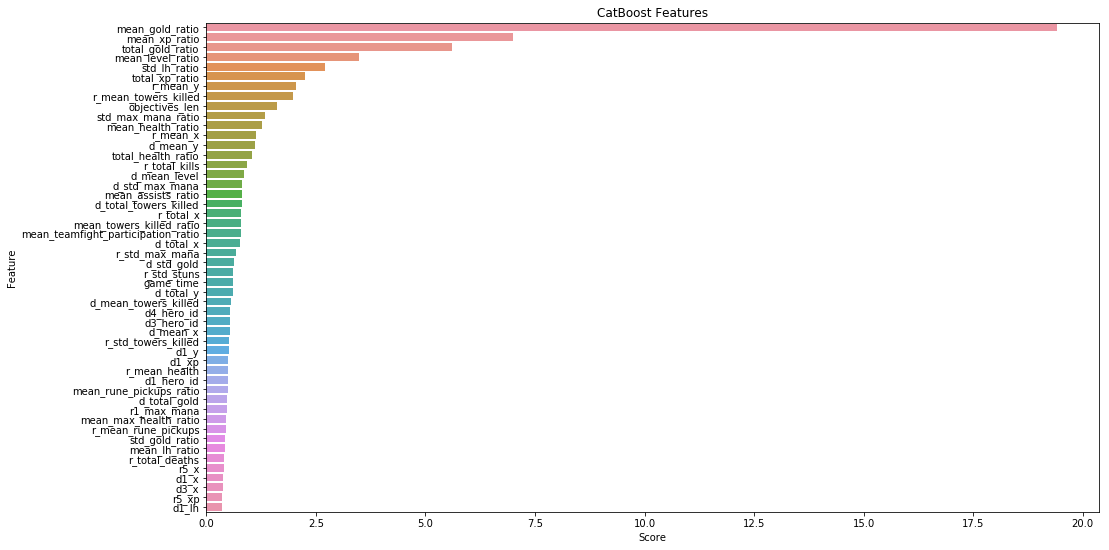

In [57]:
feature_importance_sns(cat_model_5, X5, y, figSize = (16,9))

#### Sub model 5

In [ ]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_5
sub.to_csv('submission_catBoost_model_5.csv', index=False)
sub.head()

#### pred results

### Model 5.1 - Good CatBoost Parameters

#### New parameters

In [38]:
params_cat_good = {
    'iterations' : 20000,
    'learning_rate' : 0.05,
    'loss_function':'Logloss',
    'eval_metric':'AUC', 
    'task_type': 'GPU',
    'early_stopping_rounds': 1000,
    'logging_level': 'Info', 
         }

#### drop bad parameters

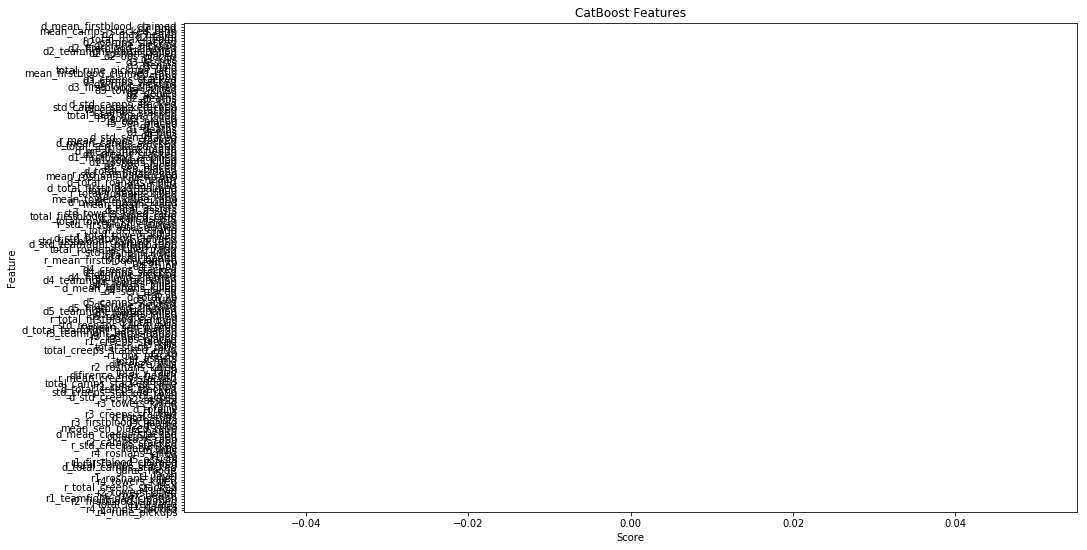

In [55]:
bad_5_1 = feature_importance_bad(cat_model_5, X5, y, col_ind, figSize = (16,9), n=175)

In [56]:
X5_1  = X5.drop(bad_5_1, axis = 1)
X_test5_1 = X_test5.drop(bad_5_1, axis = 1)

#### fit model

In [41]:
oof_cat_5_1, prediction_cat_5_1, scores_cat_5_1, cat_model_5_1 = train_model(X5,
                                                  X_test5,
                                                  y,
                                                  params=params_cat_good,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)

0it [00:00, ?it/s]

Fold 0 started at Wed Nov 13 23:58:39 2019
0:	learn: 0.8040968	test: 0.8005394	best: 0.8005394 (0)	total: 318ms	remaining: 1h 45m 59s
500:	learn: 0.8684705	test: 0.8248006	best: 0.8249434 (475)	total: 2m 14s	remaining: 1h 27m 15s
1000:	learn: 0.8969999	test: 0.8235133	best: 0.8249434 (475)	total: 4m 25s	remaining: 1h 23m 59s
bestTest = 0.8249433637
bestIteration = 475
Shrink model to first 476 iterations.


1it [06:41, 401.30s/it]

Fold 1 started at Thu Nov 14 00:05:21 2019
0:	learn: 0.8078225	test: 0.7944507	best: 0.7944507 (0)	total: 283ms	remaining: 1h 34m 18s
500:	learn: 0.8714688	test: 0.8153768	best: 0.8156644 (439)	total: 2m 16s	remaining: 1h 28m 32s
1000:	learn: 0.8989374	test: 0.8152097	best: 0.8156644 (439)	total: 4m 40s	remaining: 1h 28m 53s
bestTest = 0.815664351
bestIteration = 439
Shrink model to first 440 iterations.


2it [13:44, 407.81s/it]

Fold 2 started at Thu Nov 14 00:12:24 2019
0:	learn: 0.8030981	test: 0.8095368	best: 0.8095368 (0)	total: 273ms	remaining: 1h 31m 9s
500:	learn: 0.8650603	test: 0.8284601	best: 0.8284672 (480)	total: 2m 14s	remaining: 1h 27m 30s
1000:	learn: 0.8919472	test: 0.8280883	best: 0.8287924 (568)	total: 4m 28s	remaining: 1h 24m 54s
1500:	learn: 0.9130823	test: 0.8275852	best: 0.8287924 (568)	total: 6m 42s	remaining: 1h 22m 35s
bestTest = 0.8287923932
bestIteration = 568
Shrink model to first 569 iterations.


3it [20:55, 414.83s/it]

Fold 3 started at Thu Nov 14 00:19:35 2019
0:	learn: 0.8029323	test: 0.8045245	best: 0.8045245 (0)	total: 280ms	remaining: 1h 33m 11s
500:	learn: 0.8678626	test: 0.8308982	best: 0.8310132 (279)	total: 2m 16s	remaining: 1h 28m 24s
1000:	learn: 0.8961268	test: 0.8292522	best: 0.8310132 (279)	total: 4m 28s	remaining: 1h 24m 55s
bestTest = 0.8310132027
bestIteration = 279
Shrink model to first 280 iterations.


4it [26:49, 396.63s/it]

Fold 4 started at Thu Nov 14 00:25:29 2019
0:	learn: 0.8036938	test: 0.7983694	best: 0.7983694 (0)	total: 278ms	remaining: 1h 32m 36s
500:	learn: 0.8691586	test: 0.8255195	best: 0.8263886 (190)	total: 2m 15s	remaining: 1h 28m 8s
1000:	learn: 0.9001870	test: 0.8239431	best: 0.8263886 (190)	total: 4m 30s	remaining: 1h 25m 35s
bestTest = 0.8263885975
bestIteration = 190
Shrink model to first 191 iterations.


5it [32:22, 377.45s/it]


CV mean score: 0.8253, std: 0.0053.


In [ ]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_5_1
sub.to_csv('submission_catBoost_model_5_1.csv', index=False)
sub.head()

### Model 5.2 - Best CatBoost Parameters

## EDA

Идеи. Герои:
- связки героев
    - Висп Тини\ЦК
    - Сирена + Дизруптор
    ??
- тайминги + лейт герои
    - если игра длинная, то героии типо ТБ, АМа, ПЛа ебут
- Алхимик
    - Его команда всегда овнит по голде, но часто сосет? Проверить
- Контропики
    - Ам против Шторма

In [36]:
train_df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,difirence_kills,difirence_gold,difirence_towers_killed,difirence_max_health,difirence_max_mana,difirence_level,difirence_roshans_killed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,-1.000000,-0.319298,NaN,0.000000,-0.132659,-0.181818,NaN,0.0,0.0,0.0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.684211,0.160557,1.0,0.070248,0.041403,0.104478,NaN,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,NaN,0.294118,NaN,-0.003155,0.025788,0.000000,NaN,0.0,0.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,0.714286,0.083046,NaN,-0.008403,0.081269,0.066667,NaN,0.0,0.0,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,-0.333333,-0.063630,NaN,0.088785,0.093908,-0.019608,NaN,0.0,0.0,0.0


Попробуем глянуть на хиро какого нить

In [37]:
!grep -oEm1 '"hero_id":32,"hero_name":"[^"]+?"' $PATH_TO_DATA/train_matches.jsonl

'grep' is not recognized as an internal or external command,
operable program or batch file.


# New model

# Parameter tuning

## bayes tuning

https://www.kaggle.com/shivampanwar/catboost-and-hyperparameter-tuning-using-bayes

In [3]:
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    print.pprint(best_params)
    print()
    return best_params

In [5]:
#Skf and ROC-AUC
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Defining your search space
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [6]:
cat_for_bayes = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         od_type = 'Iter',
                         verbose= False,
                         task_type= 'CPU',
                        )

In [7]:
# Setting up BayesSearchCV
opt = BayesSearchCV(cat_for_bayes,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [12]:
best_params = report_perf(opt, X5, y,'CatBoost', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 3796.0068
Function value obtained: -0.8253
Current minimum: -0.8253
Iteration No: 2 started. Searching for the next optimal point.
CatBoost took 3796.02 seconds,  candidates checked: 1, best CV score: 0.825 ± 0.002
Best parameters:


NameError: name 'pprint' is not defined

### Save parameters

In [13]:
best_params

NameError: name 'best_params' is not defined

In [ ]:
joblib.dump(best_params, 'best_params_bayes_m5.pkl', compress = 1)

### Tuned model